In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

## Modélisation mathématique du problème

Soit:

-   $\mathbf{R} = \left\{ r_{1}, r_{2}, ..., r_{n} \right\}$ une liste de requêtes emises sur le vehicule
    
-   $ \mathbf{W} = \left\{ w_{1}, w_{2}, ..., w_{n} \right\}$ le poids associé à chaque requête
    
-   $ \mathbf{U} = \left\{ u_{1}, u_{2}, ..., u_{n} \right\}$ avec $u_{i} \epsilon \left\{ 0, 1 \right\}$ une variable binaire désignant si la requete est acceptée ou pas.
    

L’objectif est d’avoir les valeurs de U qui maximisent la moyenne pondérée des poids et minimisent l'impact négatif des requêtes sur les QoS (Temps de trajet, Quantité de carburant consommée). La fonction objective peut être formulée comme suit:
<div align="center">

$$
\max \left(\sum_{i=1}^{n} \left (w_{i} x_{i} \right) + \lambda \sum_{i=1}^{n} \left (x_{i} \left (q_{t} t_{i} + q_{c} c_{i} \right) \right)\right)
$$

</div>


Où:

-   $q_{t}$ est le poids de l'objectif temps de trajet
    
-   $t_{i}$ l'impact de la requete $r_{i}$ sur le temps de trajet
    
-   $q_{c}$ est le poids de l'objectif temps de trajet
    
-   $c_{i}$ l'impact de la requete $r_{i}$ sur le temps de trajet
    
-   $\lambda$ est un facteur de pénalité pour équilibrer l'importance des poids des requêtes et des impacts sur les QoS. (L'impact a la meme echelle que les poids).

#### Architecture

<div align="center">
    <img src="modelisation_finale.png" alt="Description de l'image">
</div>

Les $  u_{i} $ sont les sorties prédites par le modèle pour la requête 
$ i $ (probabilité d'acceptation).

Le module de prediction des impacts est constitué des deux modeles suivant chacun l'architecture suivante:

<div align="center">
    <img src="modelisation_impact.png" alt="Description de l'image">
</div>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
datas = pd.read_csv('data/final_datas.csv')

In [5]:
datas.head()

,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,ActionId,action_accelerate,action_decelerate,action_stop,ActionParam,ActionDuration,StartTime,EndTime,y_fuel,y_travel
0,1.469733,43.564755,13.140468,4.202313,0,3,0,0,1,0.000000,14,37,51,2.242222,-30.0
1,1.468177,43.566528,5.219182,0.003377,1,2,0,1,0,8.710846,9,55,64,-0.497640,-13.0
2,1.468899,43.564810,13.069221,-1.214671,1,1,1,0,0,4.531946,20,19,39,-109.744464,10.0
3,1.468901,43.565777,12.088279,-2.720630,1,1,1,0,0,9.109832,13,60,73,-75.229436,-9.0
4,1.469665,43.564765,15.709481,-0.578869,0,2,0,1,0,12.523312,5,47,52,18.707623,-27.0


#### Association d'un poids entre O et 1 a chaque requete

In [6]:
np.random.seed(42)
datas['weight'] = np.random.rand(len(datas)).round(2)

In [7]:
datas.head(5)

,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,ActionId,action_accelerate,action_decelerate,action_stop,ActionParam,ActionDuration,StartTime,EndTime,y_fuel,y_travel,weight
0,1.469733,43.564755,13.140468,4.202313,0,3,0,0,1,0.000000,14,37,51,2.242222,-30.0,0.37
1,1.468177,43.566528,5.219182,0.003377,1,2,0,1,0,8.710846,9,55,64,-0.497640,-13.0,0.95
2,1.468899,43.564810,13.069221,-1.214671,1,1,1,0,0,4.531946,20,19,39,-109.744464,10.0,0.73
3,1.468901,43.565777,12.088279,-2.720630,1,1,1,0,0,9.109832,13,60,73,-75.229436,-9.0,0.60
4,1.469665,43.564765,15.709481,-0.578869,0,2,0,1,0,12.523312,5,47,52,18.707623,-27.0,0.16


In [8]:
acceleration_req = datas[datas['action_accelerate'] == 1]

deceleration_req = datas[datas['action_decelerate'] == 1]

stop_req = datas[datas['action_stop'] == 1]

#### Generation des compostions de requetes

In [9]:
def req_by_type(num_request):
    # Répartir les requêtes de manière équilibrée entre les types
    base_count = num_request // 3
    remainder = num_request % 3

    counts = [base_count, base_count, base_count]
    for i in range(remainder):
        counts[np.random.randint(0, 3)] += 1

    num_acc, num_dec, num_stop = counts

    return num_acc, num_dec, num_stop

        

def generate_compositions( num_compositions=500 ):

    compositions = []

    for _ in range(num_compositions):
        # Nombre total de requêtes dans une composition (entre 4 et 10)
        num_request = np.random.randint(4, 11)

        num_acc, num_dec, num_stop = req_by_type(num_request)

        # Sélectionner aléatoirement les requêtes de chaque type
        acc_selected = acceleration_req.sample(n=num_acc, replace=True).copy()
        dec_selected = deceleration_req.sample(n=num_dec, replace=True).copy()
        stop_selected = stop_req.sample(n=num_stop, replace=True).copy()

        # Combiner les requêtes de différents types
        composition = pd.concat([acc_selected, dec_selected, stop_selected])

        compositions.append(composition)
    
    # # Créer un DataFrame contenant toutes les compositions
    # all_compositions = pd.concat(compositions, keys=range(num_compositions))
    # # Sauvegarder en CSV
    # all_compositions.to_csv('compositions.csv', index=True)

    return compositions

In [10]:
compositions = generate_compositions()

<Figure size 720x432 with 0 Axes>

(array([66., 78., 82., 71., 60., 68., 75.]),
 array([ 4,  5,  6,  7,  8,  9, 10, 11]),
 <BarContainer object of 7 artists>)

Text(0.5, 0, 'Nombre de requêtes par composition')

Text(0, 0.5, 'Nombre de compositions')

Text(0.5, 1.0, 'Distribution du nombre de requêtes par composition')

([<matplotlib.axis.XTick at 0x1f1249efbb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

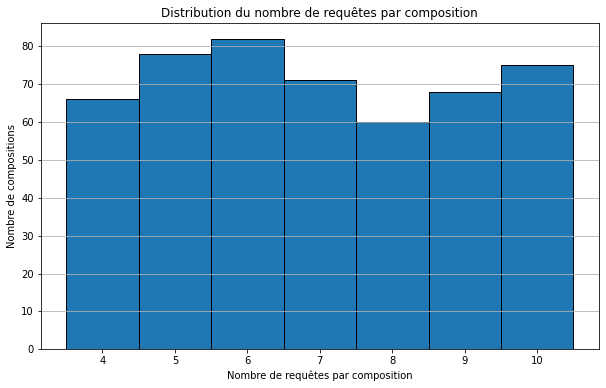

In [11]:
composition_lengths = [len(comp) for comp in compositions]

# Afficher le graphe
plt.figure(figsize=(10, 6))
plt.hist(composition_lengths, bins=range(4, 12), edgecolor='black', align='left')
plt.xlabel('Nombre de requêtes par composition')
plt.ylabel('Nombre de compositions')
plt.title('Distribution du nombre de requêtes par composition')
plt.xticks(range(4, 11))
plt.grid(axis='y')
plt.show()

In [12]:
compositions_ordered = [comp[['ActionId','ActionParam','StartTime', 'EndTime','Longitude', 
                             'Latitude', 'Speed','Acceleration', 'ActionVehicleAhead', 'weight']] for comp in compositions]

In [13]:
composition_filtered = [comp for comp in compositions_ordered if len(comp) <=6]

## Gestion des requetes

In [14]:
composition1 = composition_filtered[2]
# composition1 = composition1.values.tolist()
# composition1 = composition1[['ActionId','ActionParam','StartTime', 'EndTime','Longitude', 
#                              'Latitude', 'Speed','Acceleration', 'ActionVehicleAhead', 'y_travel', 'y_fuel', 'weight']]
composition1

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,weight
548,1,3.637788,60,79,1.467514,43.567027,15.535806,1.671466,1,0.52
1298,1,6.061398,47,62,1.468705,43.565977,13.053015,-3.865097,1,0.64
3672,2,7.288713,36,54,1.468968,43.564844,4.455834,-2.732125,2,0.72
2265,2,12.340288,50,56,1.469694,43.564756,13.846621,-2.205520,0,0.63
5148,3,0.000000,70,86,1.468117,43.566597,0.401835,0.172607,0,0.62
147,3,0.000000,30,50,1.468995,43.564858,7.125251,-0.243083,1,0.50


In [15]:
comp = composition1.values.tolist()[0]

In [16]:
comp[2: 4]

[60.0, 79.0]

In [17]:
# Conflits entre deux requetes
def conflict(req1, req2):
    """
    Vérifie s'il y a un conflit entre deux requêtes basées sur leurs temps de début et de fin.
    
    Parameters:
    request1, request2 (dict): Les requêtes avec des clés 'start_time' et 'end_time' représentant les heures de début et de fin.
    
    Returns:
    bool: True s'il y a un conflit, False sinon.
    """
    if(req1[0] != req2[0]):
        start_i, fin_i = req1[2:4]
        start_j, fin_j = req2[2:4]
        # Vérification s'il y a chevauchement entre les intervalles de temps
        if (start_i < fin_j and start_j < fin_i):
            return True
        
    return False

# Detection de conflits dans une composition
def detect_conflitcs(requests):
    """
    Trouve toutes les paires de requêtes conflictuelles dans une liste de requêtes.
    
    Parameters:
    requests (list): Liste de requêtes, chaque requête étant un dict avec des clés 'start_time' et 'end_time'.
    
    Returns:
    list: Liste de tuples contenant les paires de requêtes conflictuelles.
    """
    conflicting_pairs = []
    for i in range(len(requests)):
        for j in range(i + 1, len(requests)):
            if conflict(requests[i], requests[j]):
                    conflicting_pairs.append((i, j))
    return conflicting_pairs

def is_conflict_in_combination(combinaison):
    return False if (len(detect_conflitcs(combinaison)) == 0) else True


In [18]:
# Exemple d'utilisation
requests = composition1.values.tolist()


conflicting_pairs = detect_conflitcs(requests)

is_conflict_in_combination(requests)

True

In [19]:
pd.DataFrame(requests)

,0,1,2,3,4,5,6,7,8,9
0,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,0.52
1,1.0,6.061398,47.0,62.0,1.468705,43.565977,13.053015,-3.865097,1.0,0.64
2,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,0.72
3,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63
4,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,0.62
5,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,0.50


### Algorithme de selection des requetes

- #### Algorithme glouton 1
Dans ce algorithme, on trie les requetes suivant l'ordre decroissant des poids. Les requetes avec un plus grand poids sont donc selectionnés en premier. POur les autres requetes, on verifie s'ils sont en conflits avec les requetes deja selectionnes.

In [20]:
def greedy_request_selection(requests):
    """
    Sélectionne les requêtes suivant leur poids de sorte qu'il n'y ait pas de conflits.
    
    Parameters:
    requests (list): Liste de requêtes, chaque requête étant un dict avec des clés 'start_time', 'end_time', et 'weight'.
    
    Returns:
    list: Liste des requêtes sélectionnées.
    """
    # Trier les requêtes par poids décroissant
    sorted_requests = sorted(requests, key=lambda x: x[-1], reverse=True)

    selected_requests = []
    # Pour suivre les plages de temps déjà occupées

    # Parcourir les requêtes triées
    for request in sorted_requests:
        # Vérifier s'il y a un conflit avec les request déjà sélectionnées
        conf = False
        for selected in selected_requests:
            if conflict(request, selected):
                conf = True
                break
        
        if not conf:
            selected_requests.append(request)

    return selected_requests

In [21]:
pd.DataFrame(greedy_request_selection(requests))

,0,1,2,3,4,5,6,7,8,9
0,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,0.72
1,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63
2,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,0.62


- #### Algorithme glouton 2
Dans ce algorithme, les requetes d'abord selectionnes sont les requetes dont le type a le plus grand poids total de requetes. Les autres requetes seront selectionnes en fonction de l'absence ou non de conflits avec les requetes deja selectionnees.

In [22]:
def group_by_type_and_sum_weights(requests):
    """
    Groupe les listes suivant la valeur d'une colonne spécifique et calcule la somme d'une autre colonne pour chaque groupe.

    Parameters:
    lists (list of lists): La liste principale contenant des sous-listes.
    group_col_index (int): L'index de la colonne utilisée pour le regroupement.
    sum_col_index (int): L'index de la colonne dont on veut calculer la somme.

    Returns:
    dict: Un dictionnaire où les clés sont les valeurs de la colonne spécifiée pour le regroupement,
          et les valeurs sont la somme des valeurs de la colonne spécifiée pour chaque groupe.
    """
    grouped = {}
    
    for request in requests:
        req_type = request[0]
        req_weight = request[-1]
        
        if req_type not in grouped:
            grouped[req_type] = 0
        grouped[req_type] += req_weight
    
    return grouped



def greedy_request_selection_2(requests):
    """
    Sélectionne les requêtes sans conflit en fonction du type avec le poids total le plus élevé.

    Parameters:
    requests (list of dict): La liste de requêtes.

    Returns:
    list: Liste des requêtes sélectionnées sans conflit.
    """
    # Calculer le poids total pour chaque type de requête
    grouped_weights = group_by_type_and_sum_weights(requests)

    # Identifier le type avec le poids total le plus élevé
    max_weight_type = max(grouped_weights, key=grouped_weights.get)
    
    # Sélectionner les requêtes de ce type
    selected_requests = [req for req in requests if req[0] == max_weight_type]

    other_requests = [req for req in requests if req[0] != max_weight_type]

    for request in other_requests:
        # Vérifier s'il y a un conflit avec les request déjà sélectionnées
        conf = False
        for selected in selected_requests:
            if conflict(request, selected):
                conf = True
                break
        
        if not conf:
            selected_requests.append(request)
    return selected_requests


In [23]:
pd.DataFrame(greedy_request_selection_2(requests))

,0,1,2,3,4,5,6,7,8,9
0,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,0.72
1,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63
2,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,0.52


- #### Algorithme glouton 3 : La notion d'impact

In [24]:
#Importations des donnees de prediction

import joblib
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K

def nrmse(y_true, y_pred):
    """
    Calculate the Normalized Root Mean Square Error (NRMSE)
    """
    rms = K.sqrt(K.mean(K.square(y_pred - y_true)))
    nrmse = rms / (K.max(y_true) - K.min(y_true))
    return nrmse

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot )

scaler_fuel = joblib.load('scaler_fuel.pkl')

scaler_travel = joblib.load('scaler_travel.pkl')

model_fuel = load_model('model_fuel.h5', custom_objects={'nrmse': nrmse, 'r2_score': r2_score})
model_travel = load_model('model_travel.h5', custom_objects={'nrmse': nrmse, 'r2_score': r2_score})

rf_fuel = joblib.load('rf_fuel.joblib')
rf_travel = joblib.load('rf_travel.joblib')

In [25]:
def reorder_request(request):
    return [
        request[6],
        request[7],
        request[8],
        request[9],
        request[10],
        request[0],
        request[1],
        request[2],
        request[3],
        request[4],
        request[5]
    ]

In [26]:
# Mise a jour des requetes avec le calcul d'impacts

from sklearn.preprocessing import OneHotEncoder

def compute_requests_impacts(requests: list):
    # Quelques modifications sur la requete

    # Convertir en tableau numpy pour un traitement plus facile
    requests_array = np.array(requests)
    
    # Séparer la première colonne pour l'encodage
    first_column = requests_array[:, 0].reshape(-1, 1)
    remaining_columns = requests_array[:, 1:]

    encoder = OneHotEncoder(sparse=False)
    # Appliquer le one-hot encoding
    encoded_first_column = encoder.fit_transform(first_column)

    # Combiner les colonnes encodées avec les colonnes restantes
    encoded_requests = np.hstack((encoded_first_column, remaining_columns))

    requests_reordered = []
    for request in encoded_requests:
        requests_reordered.append(reorder_request(request))

    # Transformer les nouvelles données en utilisant les scalers chargés
    transformed_data_fuel = scaler_fuel.transform(requests_reordered)
    transformed_data_travel = scaler_travel.transform(requests_reordered)

    # Faire des prédictions avec les modèles chargés
    # predictions_fuel = model_fuel.predict(transformed_data_fuel)
    # predictions_travel = model_travel.predict(transformed_data_travel)
    predictions_fuel_rf = rf_fuel.predict(transformed_data_fuel)
    predictions_travel_rf = rf_travel.predict(transformed_data_travel)

    # Ajouter les prédictions à chaque requête
    requests_with_predictions = []
    for i, request in enumerate(requests):
        extended_request = request + [predictions_travel_rf[i], predictions_fuel_rf[i]]
        requests_with_predictions.append(extended_request)
    return requests_with_predictions

In [27]:
comp1_df = pd.DataFrame(compute_requests_impacts(requests), columns=['ActionId', 'ActionParam', 'StartTime',
                                                                     'EndTime',	'Longitude'	,'Latitude','Speed',
                                                                     'Acceleration', 'ActionVehicleAhead', 'weight', 
                                                                    'rf_predicted_travel_impact', 'rf_predicted_fuel_impact'])

In [28]:
comp1_df

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,weight,rf_predicted_travel_impact,rf_predicted_fuel_impact
0,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,0.52,7.07,-29.597807
1,1.0,6.061398,47.0,62.0,1.468705,43.565977,13.053015,-3.865097,1.0,0.64,-5.31,-84.021402
2,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,0.72,-32.72,-1.332495
3,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63,-28.70,7.004656
4,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,0.62,-36.28,6.320132
5,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,0.50,-26.95,4.963282


In [29]:
def greedy_request_selection_3(requests, travel_weight, fuel_weight):
    requests_with_impacts= compute_requests_impacts(requests)

    for req in requests_with_impacts:
        req.append(travel_weight* req[-2] + fuel_weight * req[-1])

    # Trier les requêtes selon les impacts
    sorted_requests = sorted(requests_with_impacts, key=lambda x: x[-1], reverse=True)

    selected_requests = []
    # Pour suivre les plages de temps déjà occupées

    # Parcourir les requêtes triées
    for request in sorted_requests:
        # Vérifier s'il y a un conflit avec les request déjà sélectionnées
        conf = False
        for selected in selected_requests:
            if conflict(request, selected):
                conf = True
                break
        
        if not conf:
            selected_requests.append(request)

    return selected_requests

In [30]:
pd.DataFrame(compute_requests_impacts(requests))

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,0.52,7.07,-29.597807
1,1.0,6.061398,47.0,62.0,1.468705,43.565977,13.053015,-3.865097,1.0,0.64,-5.31,-84.021402
2,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,0.72,-32.72,-1.332495
3,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63,-28.70,7.004656
4,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,0.62,-36.28,6.320132
5,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,0.50,-26.95,4.963282


In [31]:
pd.DataFrame(greedy_request_selection_3(requests, 0.5, 0.5))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63,-28.70,7.004656,-10.847672
1,3.0,0.000000,30.0,50.0,1.468995,43.564858,7.125251,-0.243083,1.0,0.50,-26.95,4.963282,-10.993359
2,1.0,3.637788,60.0,79.0,1.467514,43.567027,15.535806,1.671466,1.0,0.52,7.07,-29.597807,-11.263903


In [32]:
def compute_score(combinaison, lambdaa, travel_weight, fuel_weight):
    sum = 0
    for request in combinaison:
        sum += request[-3] + lambdaa* (travel_weight* request[-2] + fuel_weight* request[-1])

    return sum

def compute_impacts(combination, t_weight, f_weight):
    sum = 0
    for request in combination:
        sum += (t_weight* request[-2] + f_weight* request[-1])

    return sum


In [33]:
def compute_total_weight(combination):
    sum = 0
    for req in combination:
        sum += req[-3]
    return sum

In [34]:
from itertools import combinations
import math

def find_best_combination(composition):
    best_combination = []
    best_score = - math.inf

    # composition_with_impacts= compute_requests_impacts(composition)
    
    for i in range(1, len(composition)+1):
        combination_list = combinations(composition, i)
        for combo in combination_list:
            
            if not is_conflict_in_combination(combo):
                # print(pd.DataFrame(combo))
                combo_score = compute_score(combo, 0.01, 0.5, 0.5)
                if best_score < combo_score:
                    best_combination = combo
                    best_score = combo_score
    
    return best_combination, best_score


In [35]:
# find_best_combination(requests)

In [36]:
bc, bs= find_best_combination(compute_requests_impacts(requests))
pd.DataFrame(bc)
bs

,0,1,2,3,4,5,6,7,8,9,10,11
0,2.0,7.288713,36.0,54.0,1.468968,43.564844,4.455834,-2.732125,2.0,0.72,-32.72,-1.332495
1,2.0,12.340288,50.0,56.0,1.469694,43.564756,13.846621,-2.205520,0.0,0.63,-28.70,7.004656
2,3.0,0.000000,70.0,86.0,1.468117,43.566597,0.401835,0.172607,0.0,0.62,-36.28,6.320132


1.5414614636471788

In [37]:
# len(composition_ordered)

In [38]:
# def df_to_tuple(df):
#     return tuple([tuple(row) for row in df.values])

# best_combination = {}

# for i in range(len(composition_ordered)):

#     best_combination[i] = find_best_combination(composition_ordered[i].values.tolist())

In [39]:
# pd.DataFrame(best_combination[0][0])

In [40]:
# pd.DataFrame([t for t in best_combination.keys() if len(best_combination[t][0]) > 4])

In [41]:
# len(best_combination.keys())

In [42]:
pd.DataFrame(composition_filtered[163])

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,weight
3410,1,4.707073,41,48,1.468746,43.565934,14.593123,-3.577875,0,0.41
4178,1,7.372074,43,55,1.468437,43.566256,17.705084,3.512349,1,0.33
3416,2,6.660502,30,35,1.469940,43.565089,15.674146,-2.793227,1,0.31
3220,2,2.475124,18,34,1.468197,43.564407,11.854429,4.005028,2,0.51
5216,3,0.000000,60,69,1.469983,43.564960,14.127148,2.704683,3,0.44


In [43]:
pd.DataFrame(find_best_combination(composition_filtered[163].values.tolist())[0])

,0,1,2,3,4,5,6,7,8,9
0,1.0,7.372074,43.0,55.0,1.468437,43.566256,17.705084,3.512349,1.0,0.33
1,2.0,2.475124,18.0,34.0,1.468197,43.564407,11.854429,4.005028,2.0,0.51
2,3.0,0.000000,60.0,69.0,1.469983,43.564960,14.127148,2.704683,3.0,0.44


#### La methode absolue

In [44]:
# from collections import defaultdict
# from itertools import product
# from itertools import permutations

# def group_request_by_type(requests):
#     # Création d'un dictionnaire avec des listes comme valeurs par défaut
#     groupes = defaultdict(list)
    
#     # Parcours de chaque sous-liste dans la liste principale
#     for req in requests:
#         # Extraction de la valeur de la première colonne
#         cle = req[0]
#         # Ajout de la sous-liste au groupe correspondant
#         groupes[cle].append(req)
    
#     # Conversion du defaultdict en dictionnaire normal (optionnel)
#     return dict(groupes)

# def compute_total_weight(combinaison):
#     sum = 0
#     for req in combinaison:
#         sum += req[-1]
#     return sum

# # Fonction pour générer des combinaisons sans conflit pour un type de base donné
# def generate_combinations_for_base_type(base_type, grouped_requests):
#     all_combinaisons = []

#     # Obtenir les autres types de requêtes
#     other_types = [t for t in grouped_requests if t != base_type]

#     for perm in permutations(other_types):
#         combinaison = grouped_requests[base_type]
#         for other_type in perm:
#             for request in grouped_requests[other_type]:
#                 # Vérifier s'il y a un conflit avec les request déjà sélectionnées
#                 conf = False
#                 for selected in combinaison:
#                     if conflict(request, selected):
#                         conf = True
#                         break
                
#                 if not conf:
#                     combinaison.append(request)
            
#             all_combinaisons.append(combinaison)
#     return all_combinaisons

# def selection(requests):
#     best_combinaison = []
#     max_comb_weight = 0

#     # Trier les requêtes par poids décroissant
#     sorted_requests = sorted(requests, key=lambda x: x[-1], reverse=True)

#     groupes = group_request_by_type(sorted_requests)

#     # Trier chaque groupe selon le troisième élément (par exemple)
#     for base_type in groupes.keys():
#          # Obtenir les autres types de requêtes
#         other_types = [t for t in groupes if t != base_type]

#         for perm in permutations(other_types):
#             combinaison = list(groupes[base_type])
#             for other_type in perm:
#                 for request in groupes[other_type]:
#                     # Vérifier s'il y a un conflit avec les request déjà sélectionnées
#                     conf = False
#                     for selected in combinaison:
#                         if conflict(request, selected):
#                             conf = True
#                             break
                    
#                     if not conf:
#                         combinaison.append(request)
            
#             combinaison_weight = compute_total_weight(combinaison)
#             if combinaison_weight > max_comb_weight :
#                 best_combinaison = combinaison
#                 max_comb_weight = combinaison_weight

#     return best_combinaison



In [45]:
# pd.DataFrame(selection(requests))

In [46]:
comp_with_impacts = compute_requests_impacts(composition1.values.tolist())

In [47]:
composition1

,ActionId,ActionParam,StartTime,EndTime,Longitude,Latitude,Speed,Acceleration,ActionVehicleAhead,weight
548,1,3.637788,60,79,1.467514,43.567027,15.535806,1.671466,1,0.52
1298,1,6.061398,47,62,1.468705,43.565977,13.053015,-3.865097,1,0.64
3672,2,7.288713,36,54,1.468968,43.564844,4.455834,-2.732125,2,0.72
2265,2,12.340288,50,56,1.469694,43.564756,13.846621,-2.205520,0,0.63
5148,3,0.000000,70,86,1.468117,43.566597,0.401835,0.172607,0,0.62
147,3,0.000000,30,50,1.468995,43.564858,7.125251,-0.243083,1,0.50


In [48]:
composition_filtered = [comp for comp in compositions_ordered if len(comp) <=6]

In [49]:
base_name = comp

compositions_by_length = {}
compositions_with_impact = {}

for i in range(4, 11):
    compositions_by_length[i] = [comp for comp in compositions_ordered if len(comp) == i]
    compositions_with_impact[i] = []
    for j in range(len(compositions_by_length[i])):
        compositions_with_impact[i].append(compute_requests_impacts(compositions_by_length[i][j].values.tolist()))


In [50]:
pd.DataFrame(compositions_with_impact[4][0])

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,3.296977,66.0,80.0,1.467941,43.566903,4.780185,-4.000000,0.0,0.84,-24.22,-67.499667
1,2.0,11.008095,68.0,79.0,1.468530,43.566160,8.726285,-4.000000,0.0,0.79,-25.36,8.327352
2,3.0,0.000000,34.0,45.0,1.469164,43.564960,5.916271,0.601337,1.0,0.15,-28.45,-7.560540
3,3.0,0.000000,16.0,28.0,1.468079,43.564281,5.677399,1.901320,2.0,0.08,-25.73,-2.712641


### Creation du modele

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize

In [52]:
data_tensor = torch.tensor(comp_with_impacts, dtype=torch.float32).unsqueeze(0)
data_tensor

tensor([[[  1.0000,   3.6378,  60.0000,  79.0000,   1.4675,  43.5670,  15.5358,
            1.6715,   1.0000,   0.5200,   7.0700, -29.5978],
         [  1.0000,   6.0614,  47.0000,  62.0000,   1.4687,  43.5660,  13.0530,
           -3.8651,   1.0000,   0.6400,  -5.3100, -84.0214],
         [  2.0000,   7.2887,  36.0000,  54.0000,   1.4690,  43.5648,   4.4558,
           -2.7321,   2.0000,   0.7200, -32.7200,  -1.3325],
         [  2.0000,  12.3403,  50.0000,  56.0000,   1.4697,  43.5648,  13.8466,
           -2.2055,   0.0000,   0.6300, -28.7000,   7.0047],
         [  3.0000,   0.0000,  70.0000,  86.0000,   1.4681,  43.5666,   0.4018,
            0.1726,   0.0000,   0.6200, -36.2800,   6.3201],
         [  3.0000,   0.0000,  30.0000,  50.0000,   1.4690,  43.5649,   7.1253,
           -0.2431,   1.0000,   0.5000, -26.9500,   4.9633]]])

In [53]:
def objectif(composition, lambdaa, travel_weight, fuel_weight):
    obj = []
    for req in composition:
        obj.append(req[-3] + lambdaa* (travel_weight* req[-2] + fuel_weight* req[-1]))
    return obj

def true_output(batch):
    output = []
    for i in range(len(batch)):
        composition_solution, _ = find_best_combination(batch[i])
        obj = objectif(composition_solution, 0.01, 0.5, 0.5)
        max_index = obj.index(max(obj))
        best_request = composition_solution[max_index]
        # Créer une nouvelle liste avec des 0 partout sauf à l'index de la valeur maximale
        transformed_values = [[1] if req == best_request else [0] for req in batch[i]]
        output.append(transformed_values)
    return output


def all_output(batch):
    all_output = []
    for i in range(len(batch)):
        output = []
        requests = batch[i]
        composition_solution, _ = find_best_combination(batch[i])
        obj = objectif(composition_solution, 0.01, 0.5, 0.5)

        composition_solution_ordered = [x for _,x in sorted(zip(obj, composition_solution), reverse=True)]
        for j in range(len(composition_solution_ordered)):
            current_best_request = composition_solution_ordered[j]
            output.append([[1] if req == current_best_request else [0] for req in requests])
        
        for k in range(len(requests) - len(composition_solution_ordered)):
            output.append([[0]]*len(requests))

        all_output.append(output)
    return all_output

In [54]:
def filter_requests_list(requests_list, selected_requests):
    n_requests = len(requests_list)
    considered_requests = [1] *  n_requests

    for i in range(n_requests):
        if selected_requests[i] == [1]:
            considered_requests[i] = 0
            for j in range(n_requests):
                if conflict(requests_list[i], requests_list[j]):
                    considered_requests[j] = 0

    return [np.multiply(a, b).tolist() for a, b in zip(requests_list, considered_requests)]

def filter_batch(batch, selected_requests):
    new_batch= []
    for i in range(len(batch)):
        new_batch.append(filter_requests_list(batch[i], selected_requests[i]))
    return new_batch

In [55]:
# [a + b for a, b in zip([[0], [1], [0], [0]] , [[0], [0] ,[0], [1]])]
# (np.array([[0], [1], [0], [0]]) + np.array([[0], [0] ,[0], [1]])).tolist()
# comp_test = compositions_with_impact[4]
# [[0], [0], [0], [1]] * len


In [56]:
# e = objectif(find_best_combination(compositions_with_impact[5][3])[0],  0.01, 0.5, 0.5)
# br = find_best_combination(compositions_with_impact[5][3])[0][e.index(max(e))]

In [57]:
# pd.DataFrame(find_best_combination(compositions_with_impact[5][3])[0])

In [58]:
# pd.DataFrame(br).T

In [59]:
# [1 if r == br else 0 for r in compositions_with_impact[5][3]]

In [60]:
# a,b,c, d= train_test_split(compositions_with_impact[5], true_output(compositions_with_impact[5]), test_size=0.2)

In [61]:
# true_output(compositions_with_impact[7])

In [62]:
# Conversion en donnees de train et de test

pre_X_train_batch = {}
pre_X_test_batch = {}
pre_y_train_batch = {}
pre_y_test_batch = {}

for i in range(4, 11):
    X_train, X_test, y_train, y_test = train_test_split(compositions_with_impact[i], all_output(compositions_with_impact[i]), test_size=0.2)
    pre_X_train_batch[i] = X_train
    pre_X_test_batch[i] = X_test
    pre_y_train_batch[i] = y_train
    pre_y_test_batch[i] = y_test

In [63]:
def all_elements_are_zero(lst):
    return all(sublist == [0] for sublist in lst)

def add_lists(lst1, lst2):
    return [[a[0] + b[0]] for a, b in zip(lst1, lst2)]

all_elements_are_zero([[0], [0], [0], [0]])


True

In [64]:
def get_all_comp_after_filtrage(composition, all_output):
    all_comp = {}
    outputs = {}
    selected_requests = [[0]] * len(composition)

    for i in range(len(all_output)):
        if not all_elements_are_zero(all_output[i]):
            all_comp[i] = filter_requests_list(composition, selected_requests)
            outputs[i] = all_output[i]

            selected_requests = add_lists(selected_requests, outputs[i])

    return all_comp, outputs

In [65]:
def define_batch(batch_pre_input, batch_pre_output):
    batch_input = []
    batch_output = []

    for input, output in zip(batch_pre_input, batch_pre_output):
        all_comp, outputs= get_all_comp_after_filtrage(input, output)

        for i in range(len(all_comp)):
            batch_input.append(all_comp[i])
            batch_output.append(outputs[i])

    return batch_input, batch_output

In [66]:
a, b =define_batch(pre_X_train_batch[4], pre_y_train_batch[4])

### Definition des donnees d'entrainement et de test

In [67]:
X_train_batch = {}
X_test_batch = {}
y_train_batch = {}
y_test_batch = {}

for i in range(4, 11):
    train =  define_batch(pre_X_train_batch[i], pre_y_train_batch[i])
    test =  define_batch(pre_X_test_batch[i], pre_y_test_batch[i])

    X_train_batch[i] = torch.tensor(train[0], dtype=torch.float32) 
    y_train_batch[i] = torch.tensor(train[1], dtype=torch.float32) 

    X_test_batch[i] = torch.tensor(test[0], dtype=torch.float32) 
    y_test_batch[i] = torch.tensor(test[1], dtype=torch.float32) 

In [68]:
# torch.save(X_train_batch, 'tensors/X_train.pt')
# torch.save(X_test_batch, 'tensors/X_test.pt')
# torch.save(y_train_batch, 'tensors/y_train.pt')
# torch.save(y_test_batch, 'tensors/y_test.pt')

In [69]:
tensor_batch = {}
batch_x_train= {}
batch_x_test = {}
batch_y_train = {}
batch_y_test = {}

for i in range(4, 11):
    X_train, X_test, y_train, y_test = train_test_split(compositions_with_impact[i], all_output(compositions_with_impact[i]), test_size=0.2)
    batch_x_train[i]= torch.tensor(X_train, dtype=torch.float32)
    batch_x_test[i] = torch.tensor(X_test, dtype=torch.float32)
    batch_y_train[i] = torch.tensor(y_train, dtype=torch.float32)
    batch_y_test[i] = torch.tensor(y_test, dtype=torch.float32)


In [70]:
class RequestSelector(nn.Module):
    def __init__(self, embed_size, num_heads, dropout = 0.1) -> None:
        super(RequestSelector, self).__init__()
        # self.attention = nn.MultiheadAttention(embed_size, num_heads)
        self.attention = nn.TransformerEncoderLayer(d_model= embed_size, nhead= num_heads)
        self.linear1 = nn.Linear(embed_size, 16)
        # self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.linear2 = nn.Linear(16, 32)
        # self.bn2 = nn.BatchNorm1d(hidden_dim2)

        self.linear3 = nn.Linear(32, 64)

        self.linear4 = nn.Linear(64, 32)

        self.linear5 = nn.Linear(32, 16)

        self.linear6 = nn.Linear(16, 1)

        self.dropout = nn.Dropout(dropout)
        
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim= 1)
        

    def forward(self, x, mask=None):
        # attn_output, _ = self.attention(x, x, x, key_padding_mask=mask)
        attn_output = self.attention(x)

        attn_output += x

        hidden = self.relu(self.linear1(attn_output))
        
        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear2(hidden))

        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear3(hidden))

        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear4(hidden))

        # hidden = self.dropout(hidden)

        hidden = self.relu(self.linear5(hidden))

        # hidden = self.dropout(hidden)

        # Passe les résultats par une couche dense pour obtenir une seule valeur par requête
        scores = self.linear6(hidden)  # (batch_size, 1)
                
        # Utiliser softmax pour obtenir la distribution de probabilité
        probabilities = self.softmax(scores)  # (batch_size, num_queries)
        
        return probabilities


In [71]:
def correct_prediction(outputs, target):
    correct = 0

    # Trouver l'index du score maximum pour chaque échantillon
    max_indices = torch.argmax(outputs, dim=1, keepdim=True)
    
    # Créer une matrice de zéros de la même forme que les sorties
    predicted = torch.zeros_like(outputs)

    # Mettre l'élément correspondant au score max à 1
    _ = predicted.scatter_(1, max_indices, 1)

    correct += (predicted ==target).all(dim=1).sum().item()

    return correct

In [72]:
correct_prediction(y_train_batch[4], y_train_batch[4])

# len(y_train_batch[5])

111

In [73]:
model = RequestSelector(12, 1)
print(model)

RequestSelector(
  (attention): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=12, out_features=12, bias=True)
    )
    (linear1): Linear(in_features=12, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=12, bias=True)
    (norm1): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear1): Linear(in_features=12, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=16, bias=True)
  (linear6): Linear(in_features=16, out_features=1, bias=True)
  (dropout): D

In [74]:
criterion = nn.CrossEntropyLoss()  # Fonction de perte pour classification
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [75]:
# Liste pour stocker la perte moyenne de chaque époque
losses = []
val_losses = []

acc = []
val_acc = []

num_epochs = 500
train_correct = 0 
test_correct = 0

train_total = 0
test_total = 0

for epoch in range(num_epochs):
    _ = model.train()
    running_loss = 0

    for i in range(4, 11):
        # optimizer.zero_grad()
        optimizer.zero_grad()  # Réinitialiser les gradients
        outputs = model(X_train_batch[i])  # Passer les données dans le modèle
        loss = criterion(outputs, y_train_batch[i])  # Calculer la perte
        loss.backward()  # Calculer les gradients
        optimizer.step()  # Mettre à jour les paramètres du modèle

        train_correct += correct_prediction(outputs, y_train_batch[i])

        train_total += y_train_batch[i].size(0)
        
        running_loss += loss.item()

    avg_loss = running_loss / len(X_train_batch)

    losses.append(avg_loss)  # Enregistrer la perte moyenne de l'époque
    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Boucle d'évaluation
    _ = model.eval()  # Mode évaluation
    running_val_loss = 0

    with torch.no_grad():  # Pas de calcul de gradients pendant la validation
        for i in range(4, 11):
            val_outputs = model(X_test_batch[i])  # Passer les données de validation dans le modèle
            val_loss = criterion(val_outputs, y_test_batch[i])  # Calculer la perte de validation
            running_val_loss += val_loss.item()

            test_correct += correct_prediction(val_outputs, y_test_batch[i])

            test_total += y_test_batch[i].size(0)

    avg_val_loss = running_val_loss / len(X_test_batch)
    val_losses.append(avg_val_loss) 

    acc.append((train_correct/train_total))
    val_acc.append((test_correct/test_total))
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_loss:.4f}, Val Avg Loss: {avg_val_loss:.4f}, Accuracy: {(train_correct/train_total):.2f}, Val Accuracy: {(test_correct/test_total):.2f}')
        

Epoch [1/500], Avg Loss: 1.8993, Val Avg Loss: 1.8419, Accuracy: 0.32, Val Accuracy: 0.42
Epoch [2/500], Avg Loss: 1.7277, Val Avg Loss: 1.6891, Accuracy: 0.37, Val Accuracy: 0.41
Epoch [3/500], Avg Loss: 1.6916, Val Avg Loss: 1.6445, Accuracy: 0.39, Val Accuracy: 0.43
Epoch [4/500], Avg Loss: 1.6625, Val Avg Loss: 1.6212, Accuracy: 0.41, Val Accuracy: 0.45
Epoch [5/500], Avg Loss: 1.6568, Val Avg Loss: 1.6097, Accuracy: 0.42, Val Accuracy: 0.46
Epoch [6/500], Avg Loss: 1.6475, Val Avg Loss: 1.6084, Accuracy: 0.43, Val Accuracy: 0.47
Epoch [7/500], Avg Loss: 1.6438, Val Avg Loss: 1.6083, Accuracy: 0.44, Val Accuracy: 0.47
Epoch [8/500], Avg Loss: 1.6433, Val Avg Loss: 1.6047, Accuracy: 0.44, Val Accuracy: 0.48
Epoch [9/500], Avg Loss: 1.6354, Val Avg Loss: 1.5994, Accuracy: 0.45, Val Accuracy: 0.49
Epoch [10/500], Avg Loss: 1.6287, Val Avg Loss: 1.6065, Accuracy: 0.45, Val Accuracy: 0.49
Epoch [11/500], Avg Loss: 1.6179, Val Avg Loss: 1.6052, Accuracy: 0.46, Val Accuracy: 0.49
Epoch [1

In [76]:
# # Boucle d'évaluation
#     _ = model.eval()  # Mode évaluation
#     with torch.no_grad():
#         correct = 0
#         total = 0

#         for i in range(4, 11):
#             test_outputs = model(X_test_batch[i])

#             # Trouver l'index du score maximum pour chaque échantillon
#             max_indices = torch.argmax(test_outputs, dim=1, keepdim=True)
            
#             # Créer une matrice de zéros de la même forme que les sorties
#             predicted = torch.zeros_like(test_outputs)

#             # Mettre l'élément correspondant au score max à 1
#             _ = predicted.scatter_(1, max_indices, 1)

#             total += y_test_batch[i].size(0)

#             correct += (predicted == y_test_batch[i]).all(dim=1).sum().item()

#         accuracy = 100 * correct / total
#         print(f'Accuracy on test set: {accuracy:.2f}%')

<Figure size 1440x720 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'Evolution of Training and Validation Loss over Epochs')

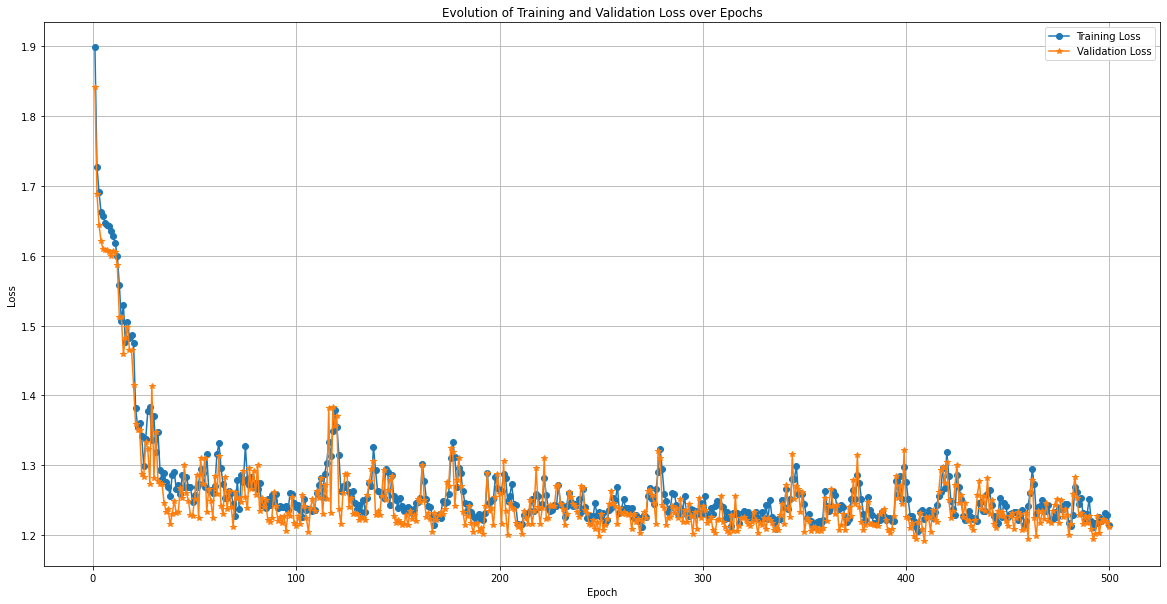

In [77]:
import matplotlib.pyplot as plt

# Exemple de code pour afficher les courbes de perte d'entraînement et de validation
plt.figure(figsize=(20, 10))

# Courbe de perte d'entraînement
plt.plot(range(1, num_epochs + 1), losses, marker='o', label='Training Loss')

# Courbe de perte de validation
plt.plot(range(1, num_epochs + 1), val_losses, marker='*', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolution of Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1440x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Precision')

Text(0.5, 1.0, 'Evolution of Precision over Epochs')

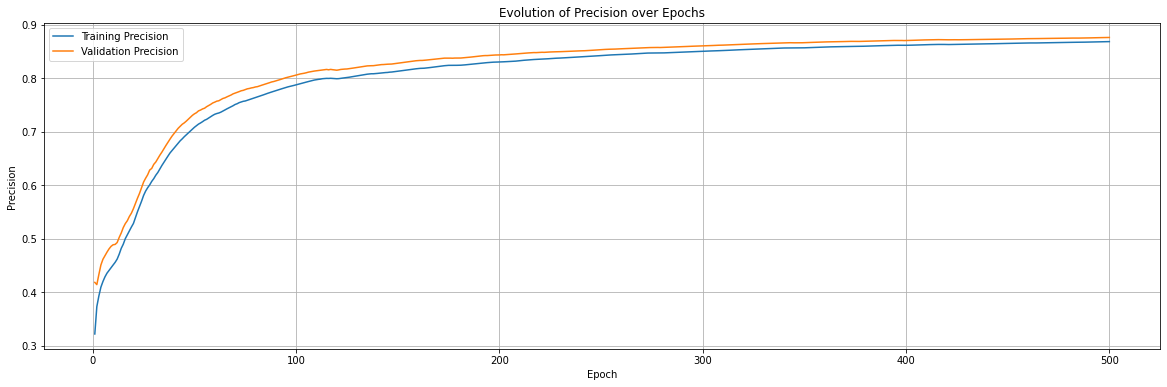

In [78]:
# Tracé des courbes de précision


plt.figure(figsize=(20, 6))

plt.plot(range(1, num_epochs + 1), acc, label='Training Precision')
plt.plot(range(1, num_epochs + 1), val_acc, label='Validation Precision')

plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Evolution of Precision over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
torch.save(model.state_dict, 'model_weights.pth')

In [80]:
def not_zero_req(req):
    return torch.any(req != 0).item()

def count_non_zero_requests(composition):
    return sum(not_zero_req(req) for req in composition)

def mean_non_zero_in_batch(batch):
    non_zero_counts = [count_non_zero_requests(comp) for comp in batch]
    return sum(non_zero_counts) / len(batch)

In [81]:
mean_non_zero_in_batch(batch_x_train[4])

4.0

In [82]:
def is_comp_null(comp):
    return torch.all(comp == 0).item()

In [83]:
tensor_test = torch.Tensor(pre_X_train_batch[4][0])

In [84]:
is_comp_null(tensor_test)

False

#### 2e test

In [85]:
def convert_to_one_hot(probs):
    # Trouver l'indice de la plus grande probabilité le long de la première dimension
    max_index = torch.argmax(probs, dim=0)
    
    # Créer un vecteur de zéros de la même taille que probs
    one_hot = torch.zeros_like(probs)
    
    # Mettre 1 à l'indice de la plus grande probabilité
    one_hot[max_index] = 1
    
    return one_hot

In [86]:
convert_to_one_hot(torch.Tensor([[0.6], [0.2], [0.2], [0.7]]))

tensor([[0.],
        [0.],
        [0.],
        [1.]])

In [87]:
convert_to_one_hot(torch.tensor([[1.],
        [1.],
        [1.],
        [1.]]))

tensor([[1.],
        [0.],
        [0.],
        [0.]])

In [107]:
def get_selected_request(composition, prob):
    index = next(i for i, val in enumerate(prob) if val[0]==1)
    return composition[index]

def get_all_selected_request(composition, selected_reqs):
    indices = [i for i,val in enumerate(selected_reqs) if val[0]==1]
    return [composition[i] for i in indices]

In [89]:
pd.DataFrame(pre_X_train_batch[4][0])

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.0,5.217464,29.0,39.0,1.469157,43.564952,4.854713,-0.456051,1.0,0.11,-15.80,-75.885219
1,1.0,3.819731,56.0,68.0,1.468057,43.566672,5.013065,0.494465,1.0,0.94,-5.59,-54.801720
2,2.0,10.020561,40.0,52.0,1.468681,43.566002,18.192735,2.236198,0.0,0.55,1.00,17.968881
3,3.0,0.000000,38.0,44.0,1.469282,43.564997,5.542980,1.646563,0.0,0.62,-30.02,-10.575520


In [130]:
def prediction(composition: list):
    selected_requests = [[0]] * len(composition)
    current_select = []
    current_score = - math.inf

    while not is_comp_null(torch.Tensor(composition)):

        composition = filter_requests_list(composition, selected_requests)
        # print(pd.DataFrame(composition))
        step_selected_request = convert_to_one_hot(model(torch.Tensor(composition).unsqueeze(0))[0])

        # print(step_selected_request)

        current_select.append(get_selected_request(composition, step_selected_request.tolist()))

        new_score = sum(objectif(current_select, 0.01, 0.5, 0.5))

        # print(objectif(current_select, 0.01, 0.5, 0.5))
        # print(sum(objectif(current_select, 0.01, 0.5, 0.5)))

        # print(f"New score : {new_score}, Current score: {current_score}")
        if new_score > current_score:
            current_score = new_score
            selected_requests = (torch.Tensor(selected_requests) + step_selected_request).tolist()

        else: 
            break
        

    return selected_requests

In [131]:
prediction(pre_X_test_batch[5][10])

[[0.0], [1.0], [1.0], [0.0], [1.0]]

In [109]:
pre_y_test_batch[5][10]

[[[0], [1], [0], [0], [0]],
 [[0], [0], [1], [0], [0]],
 [[0], [0], [0], [0], [1]],
 [[0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0]]]

In [118]:
def get_all_output_vector(true_output):
    output_array = np.array(true_output)
    return output_array.sum(axis=0).tolist()

In [119]:
get_all_output_vector(pre_y_test_batch[5][10])

[[0], [1], [1], [0], [1]]

In [132]:
true_test_score = {}

def compute_true_score(batch, batch_output):
    true_score = []
    for input, output in zip(batch, batch_output):
        output_vector = get_all_output_vector(output)
        true_selected_requests = get_all_selected_request(input, output_vector)

        true_score.append(sum(objectif(true_selected_requests, 0.01, 0.5, 0.5)))

    return true_score

def compute_predicted_score(batch):
    predicted_score = []
    for i in range(len(batch)):
        output_vector = prediction(batch[i])
        predicted_selected_requests = get_all_selected_request(batch[i], output_vector)

        predicted_score.append(sum(objectif(predicted_selected_requests, 0.01, 0.5, 0.5)))

    return predicted_score

        

In [156]:
pred = compute_predicted_score(pre_X_test_batch[10])

In [157]:
real = compute_true_score(pre_X_test_batch[10], pre_y_test_batch[10])

In [160]:
predicted_scores = {}
real_scores = {}

for i in range(4, 11):
    predicted_scores[i] = compute_predicted_score(pre_X_test_batch[i])

    real_scores[i] = compute_true_score(pre_X_test_batch[i], pre_y_test_batch[i])

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Comparaison')

Text(0.5, 0, 'Echantillons')

Text(0, 0.5, 'Scores')

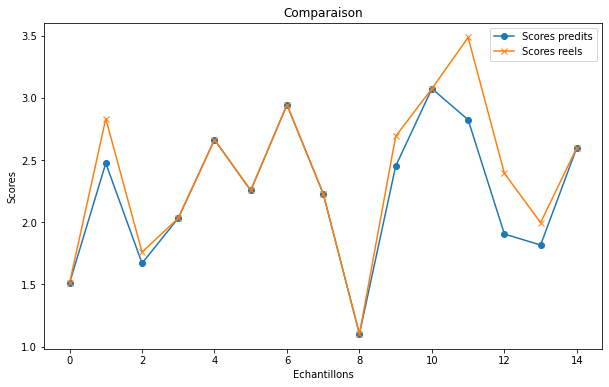

In [161]:
plt.figure(figsize=(10,6))
plt.plot(predicted_scores[10], label='Scores predits', marker='o')

plt.plot(real_scores[10], label='Scores reels', marker='x')

plt.title('Comparaison score reel vs predite')
plt.xlabel('Echantillons')
plt.ylabel('Scores')
plt.legend()

plt.show()

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 4 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 5 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 6 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 7 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 8 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 9 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, 'Comparaison score réel vs prédit pour 10 requêtes')

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

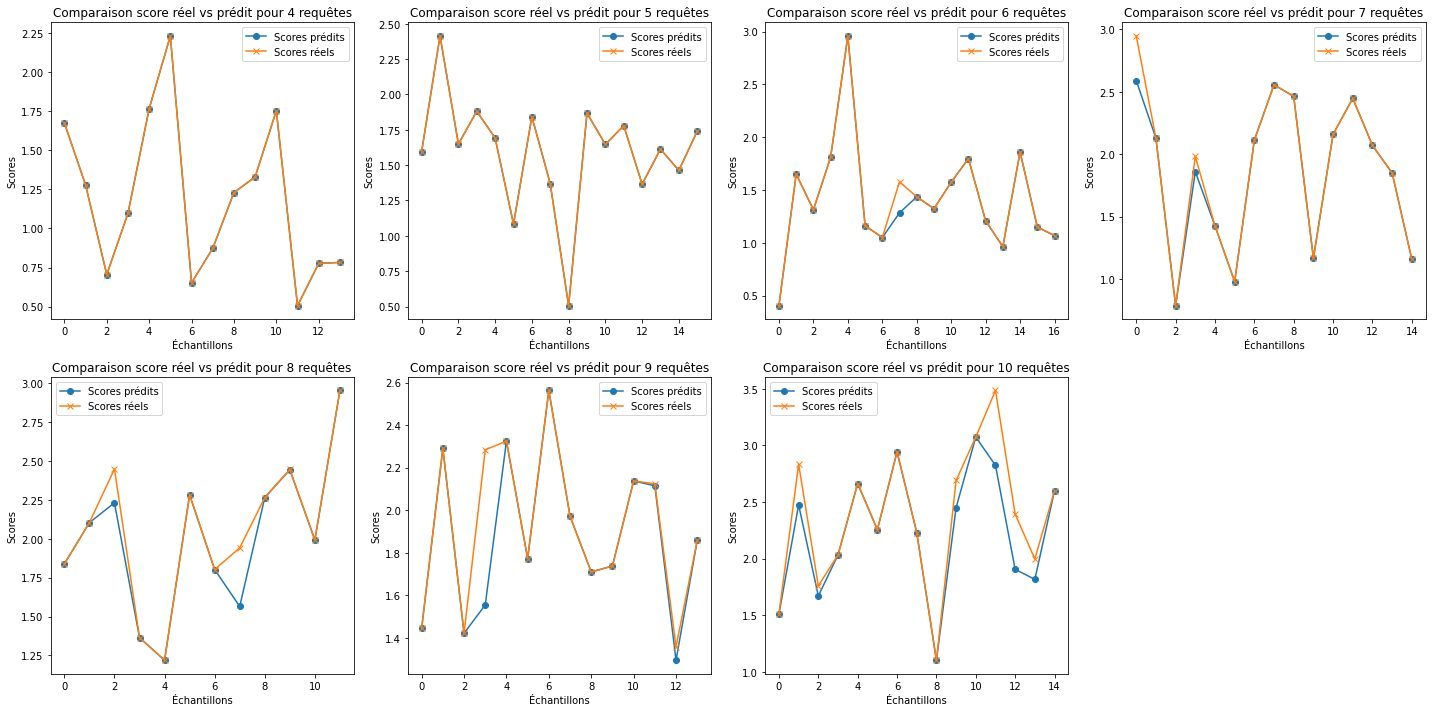

In [171]:
num_plots = len(predicted_scores)  # Le nombre total de sous-graphiques
num_cols = 4  # Nombre de colonnes
num_rows = 2  # Nombre de lignes

plt.figure(figsize=(20, 10))  # Ajustez la taille de la figure

for idx, i in enumerate(predicted_scores.keys()):
    plt.subplot(num_rows, num_cols, idx + 1)  # Crée un sous-graphe dans une grille de 2 lignes et 4 colonnes
    plt.plot(predicted_scores[i], label='Scores prédits', marker='o')
    plt.plot(real_scores[i], label='Scores réels', marker='x')

    plt.title(f'Comparaison score réel vs prédit pour {i} requêtes')
    plt.xlabel('Échantillons')
    plt.ylabel('Scores')
    plt.legend()

plt.tight_layout()  # Ajuste l'espacement entre les sous-graphiques
plt.show()

<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 4")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 5")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 6")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 7")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 8")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 9")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 10")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

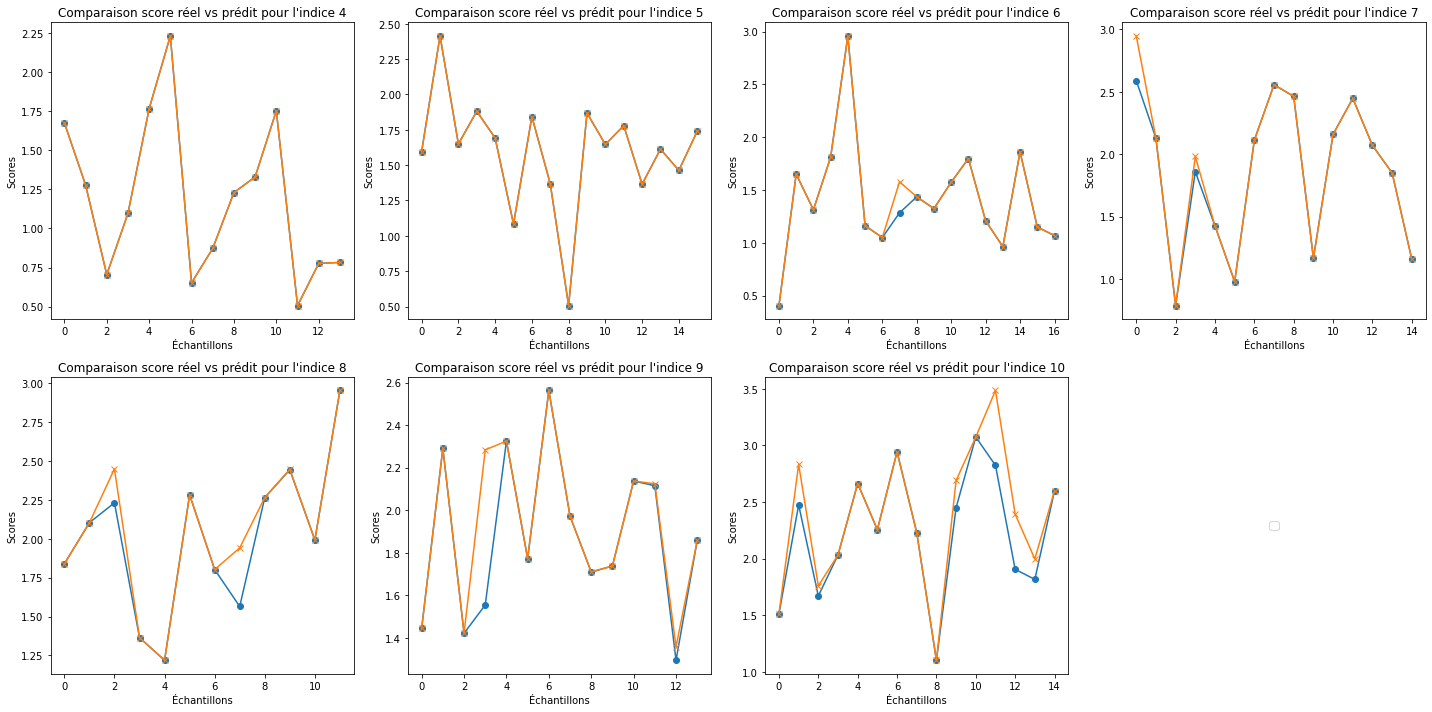

In [169]:
num_plots = len(predicted_scores)  # Le nombre total de sous-graphiques
num_cols = 4  # Nombre de colonnes
num_rows = 2  # Nombre de lignes

plt.figure(figsize=(20, 10))  # Ajustez la taille de la figure

for idx, i in enumerate(predicted_scores.keys()):
    plt.subplot(num_rows, num_cols, idx + 1)  # Crée un sous-graphe dans une grille de 2 lignes et 4 colonnes
    plt.plot(predicted_scores[i], label='Scores prédits', marker='o')
    plt.plot(real_scores[i], label='Scores réels', marker='x')

    plt.title(f'Comparaison score réel vs prédit pour l\'indice {i}')
    plt.xlabel('Échantillons')
    plt.ylabel('Scores')

# Ajouter les labels à la dernière colonne en fusionnant les cellules
plt.subplot(num_rows, num_cols, 8)  # Place dans la dernière cellule
plt.axis('off')  # Désactive l'affichage de l'axe
plt.legend(['Scores prédits', 'Scores réels'], loc='center', fontsize='large')  # Affiche les labels au centre

plt.tight_layout()  # Ajuste l'espacement entre les sous-graphiques
plt.show()


<Figure size 1440x720 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 4")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 5")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 6")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 7")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 8")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 9")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

Text(0.5, 1.0, "Comparaison score réel vs prédit pour l'indice 10")

Text(0.5, 0, 'Échantillons')

Text(0, 0.5, 'Scores')

<AxesSubplot:>

(0.0, 1.0, 0.0, 1.0)

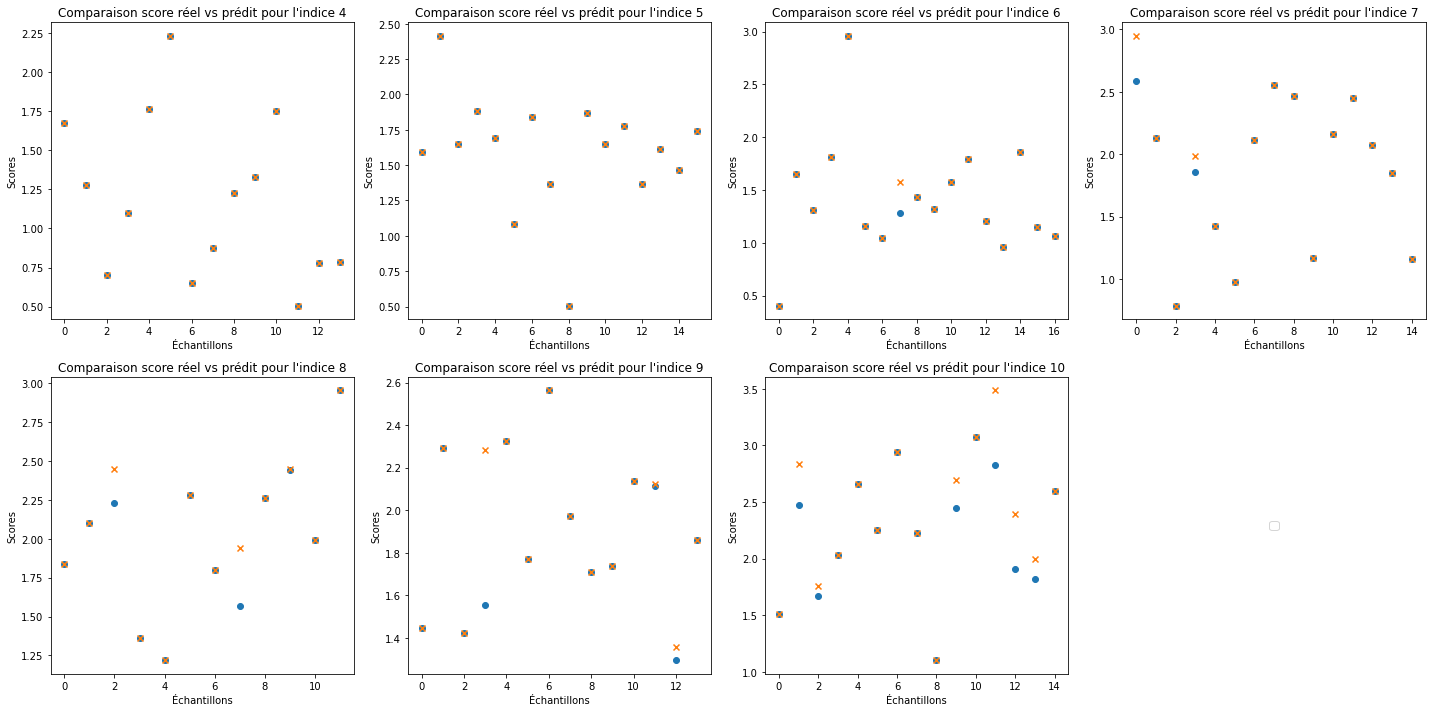

In [170]:
num_plots = len(predicted_scores)  # Le nombre total de sous-graphiques
num_cols = 4  # Nombre de colonnes
num_rows = 2  # Nombre de lignes

plt.figure(figsize=(20, 10))  # Ajustez la taille de la figure

for idx, i in enumerate(predicted_scores.keys()):
    plt.subplot(num_rows, num_cols, idx + 1)  # Crée un sous-graphe dans une grille de 2 lignes et 4 colonnes
    plt.scatter(range(len(predicted_scores[i])), predicted_scores[i], label='Scores prédits', marker='o')
    plt.scatter(range(len(real_scores[i])), real_scores[i], label='Scores réels', marker='x')

    plt.title(f'Comparaison score réel vs prédit pour l\'indice {i}')
    plt.xlabel('Échantillons')
    plt.ylabel('Scores')

# Ajouter les labels à la dernière colonne en fusionnant les cellules
plt.subplot(num_rows, num_cols, 8)  # Place dans la dernière cellule
plt.axis('off')  # Désactive l'affichage de l'axe
plt.legend(['Scores prédits', 'Scores réels'], loc='center', fontsize='large')  # Affiche les labels au centre

plt.tight_layout()  # Ajuste l'espacement entre les sous-graphiques
plt.show()